In [1]:
# Помощь в визуализации
%matplotlib inline
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Аугментации
# %pip install -qqq albumentations
import albumentations as A

import torch
from torch import nn
from torch import optim
!pip install -qqq segmentation_models_pytorch
import segmentation_models_pytorch as smp

# Логирование
!pip install wandb -qqq
import wandb
!wandb login

print('Ready to work')

wandb: Currently logged in as: infin (hdh). Use `wandb login --relogin` to force relogin
Ready to work


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data installation

In [3]:
# %%capture
# %cd /content
# !mkdir datasets/
# !mkdir datasets/voc
# !mkdir datasets/coco
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf 'VOCtrainval_11-May-2012.tar' -C datasets/voc
# !wget http://images.cocodataset.org/zips/train2017.zip
# !unzip -q train2017.zip -d datasets/coco
# !wget http://images.cocodataset.org/zips/val2017.zip
# !unzip -q val2017.zip -d datasets/coco
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !unzip -q annotations_trainval2017.zip -d datasets/coco

In [4]:
%cd /content/drive/MyDrive/AI/mindset
!ls

/content/drive/MyDrive/AI/mindset
configs    geeks.jpg  __pycache__	  Training.ipynb  wandb
EDA.ipynb  modeling   train_functions.py  utils		  weights


# Config and settings

In [5]:
from utils import Config 
cfg = Config()

cfg.voc_data_folder = '/content/datasets/voc/VOCdevkit/VOC2012'
cfg.save_folder = ''
cfg.save_name = 'UnetEfb6AllCatsWithVOCAllCats'

cfg.coco_annotations = '/content/datasets/coco/annotations/instances_train2017.json'

# Setting seed
cfg.seed = 42

# Model settings
cfg.pretrained = False
cfg.epochs = 12
cfg.lr = 3e-4

# Dataloading
cfg.batch_size = 4
cfg.val_size = 0.3

# Cross-validation
cfg.kfold = False
# cfg.n_splits = 3
# cfg.fold_number = 1

# Data loading

In [6]:
#!g1.1
cfg.pre_transforms = [
    dict(
        name="Resize",
        params=dict(
            height=512,
            width=512,
            p=1.0,
        )
    ),
]

cfg.augmentations = [
    dict(
        name="HorizontalFlip",
        params=dict(
            p=0.5)
    ),
    dict(
        name="RandomBrightnessContrast",
        params=dict(
            p=0.3)
    ),
#     dict(
#         name="VerticalFlip",
#         params=dict(
#             p=0.5)
#     ),
# #     dict(
# #         name="ElasticTransform",
# #         params=dict(
# #             p=0.5)
# #     ),
#     dict(
#         name="RandomRotate90",
#         params=dict()
#     ),
#     class albumentations.augmentations.geometric.transforms.ElasticTransform 
]

cfg.post_transforms = []

In [7]:
from utils.datagenerator import get_loaders, get_paths
# get_paths(cfg.voc_data_fodler)
train_dl, val_dl = get_loaders(cfg)

loading annotations into memory...
Done (t=16.44s)
creating index...
index created!
loading annotations into memory...
Done (t=14.29s)
creating index...
index created!


In [8]:
len(train_dl)

620

In [10]:
a = next(iter(train_dl))
a[0][0].shape, a[1][0].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

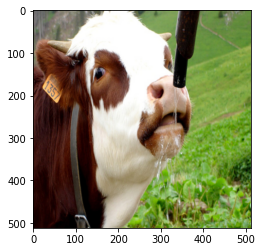

In [11]:
plt.imshow(a[0][2].permute(1, 2, 0))

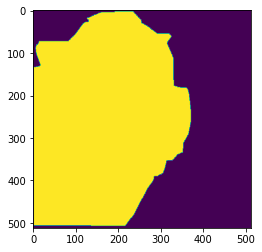

In [12]:
plt.imshow(a[1][2][0, :, :])

# Train


In [13]:
cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg.model = 'Unet' #@param ['DeepLabV3', 'Unet', 'UnetPlusPlus']
cfg.backbone = 'efficientnet-b6' #@param [ 'None', 'resnet101', 'resnet50', 'resnet34', 'resnext101_32x4d', 'resnet152', 'efficientnet-b7', 'efficientnet-b6', 'efficientnet-b5']
cfg.in_channels = 3
cfg.num_classes = 1
cfg.layers_to_freeze = 0
cfg.max_early_stopping = 2

cfg.metric = 'IoUScore' #@param ['IoUScore', 'IoUScoreBinary', 'DiceScore']
cfg.metric_params = dict()
cfg.criterion = 'IoULoss' #@param ['IoULoss', 'BCELoss', 'DiceLoss', 'FocalLoss']
cfg.criterion_params = dict()

cfg.optimizer = 'Adam'
cfg.optimizer_params = dict(
    lr=cfg.lr
)


cfg.scheduler = 'OneCycleLR'
cfg.scheduler_params = dict(
    max_lr=cfg.lr,
    epochs=cfg.epochs,
    steps_per_epoch=len(train_dl)
)

# cfg.scheduler = None
# cfg.scheduler_params = dict(
#     lr=cfg.lr
# )

In [14]:
!nvidia-smi

Mon May  9 21:52:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
from train_functions import run

# cfg.pretrained = 'weights/UnetPP-efnb7-1024-o f-IoULoss-0.18118978592387416.pth'
cfg.save(replace=True)
model = run(cfg, use_wandb=True)

loading annotations into memory...
Done (t=17.20s)
creating index...
index created!
loading annotations into memory...
Done (t=17.07s)
creating index...
index created!


wandb: Currently logged in as: infin (hdh). Use `wandb login --relogin` to force relogin


Epoch #1


100%|██████████| 620/620 [06:12<00:00,  1.66it/s]


      Score    |    Loss
Train: 0.584535 | 0.472526


100%|██████████| 266/266 [00:51<00:00,  5.19it/s]


Val: 0.826677 | 0.249035

Epoch #2


100%|██████████| 620/620 [06:13<00:00,  1.66it/s]


      Score    |    Loss
Train: 0.816479 | 0.197836


100%|██████████| 266/266 [00:50<00:00,  5.22it/s]


Val: 0.841516 | 0.152851

Epoch #3


100%|██████████| 620/620 [06:12<00:00,  1.66it/s]


      Score    |    Loss
Train: 0.827949 | 0.163531


100%|██████████| 266/266 [00:51<00:00,  5.13it/s]


Val: 0.830540 | 0.159223

Epoch #4


100%|██████████| 620/620 [06:12<00:00,  1.67it/s]


      Score    |    Loss
Train: 0.829556 | 0.159008


100%|██████████| 266/266 [00:51<00:00,  5.12it/s]


Val: 0.847810 | 0.139561

Epoch #5


100%|██████████| 620/620 [06:13<00:00,  1.66it/s]


      Score    |    Loss
Train: 0.842427 | 0.145117


100%|██████████| 266/266 [00:51<00:00,  5.14it/s]


Val: 0.838535 | 0.152355

<<< EarlyStopping >>>


lr,▁▅▇█▇
train_loss,█▂▁▁▁
train_score,▁▇███
val_loss,█▂▂▁▂
val_score,▁▆▂█▅
lr,0.00028
train_loss,0.14512
train_score,0.84243
val_loss,0.15236
val_score,0.83853


In [16]:
class Unet(nn.Module):
    def __init__(self, cfg):
        super(Unet, self).__init__()
        self.cfg = cfg
        self.model = smp.Unet(cfg.backbone, classes=cfg.num_classes,
                              activation='softmax' if cfg.num_classes > 1 else 'sigmoid',
                              in_channels=cfg.in_channels)

        for i, x in enumerate(self.model.encoder.children()):
            if isinstance(x, torch.nn.Sequential):
                if cfg.layers_to_freeze:
                    for param in x.parameters():
                        param.requires_grad = False
                    cfg.layers_to_freeze -= 1

    def forward(self, x):
        return self.model(x)

In [17]:
model = Unet(cfg)
model.load_state_dict(torch.load('weights/UnetEfb6AllCatsWithVOCAllCats-IoULoss-0.1395610857726936.pth'))
model.eval()

Unet(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            56, 14, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            14, 56, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()

In [18]:
from utils import get_loaders
cfg.batch_size = 1
train_dl, val_dl = get_loaders(cfg)

loading annotations into memory...
Done (t=17.85s)
creating index...
index created!
loading annotations into memory...
Done (t=17.12s)
creating index...
index created!


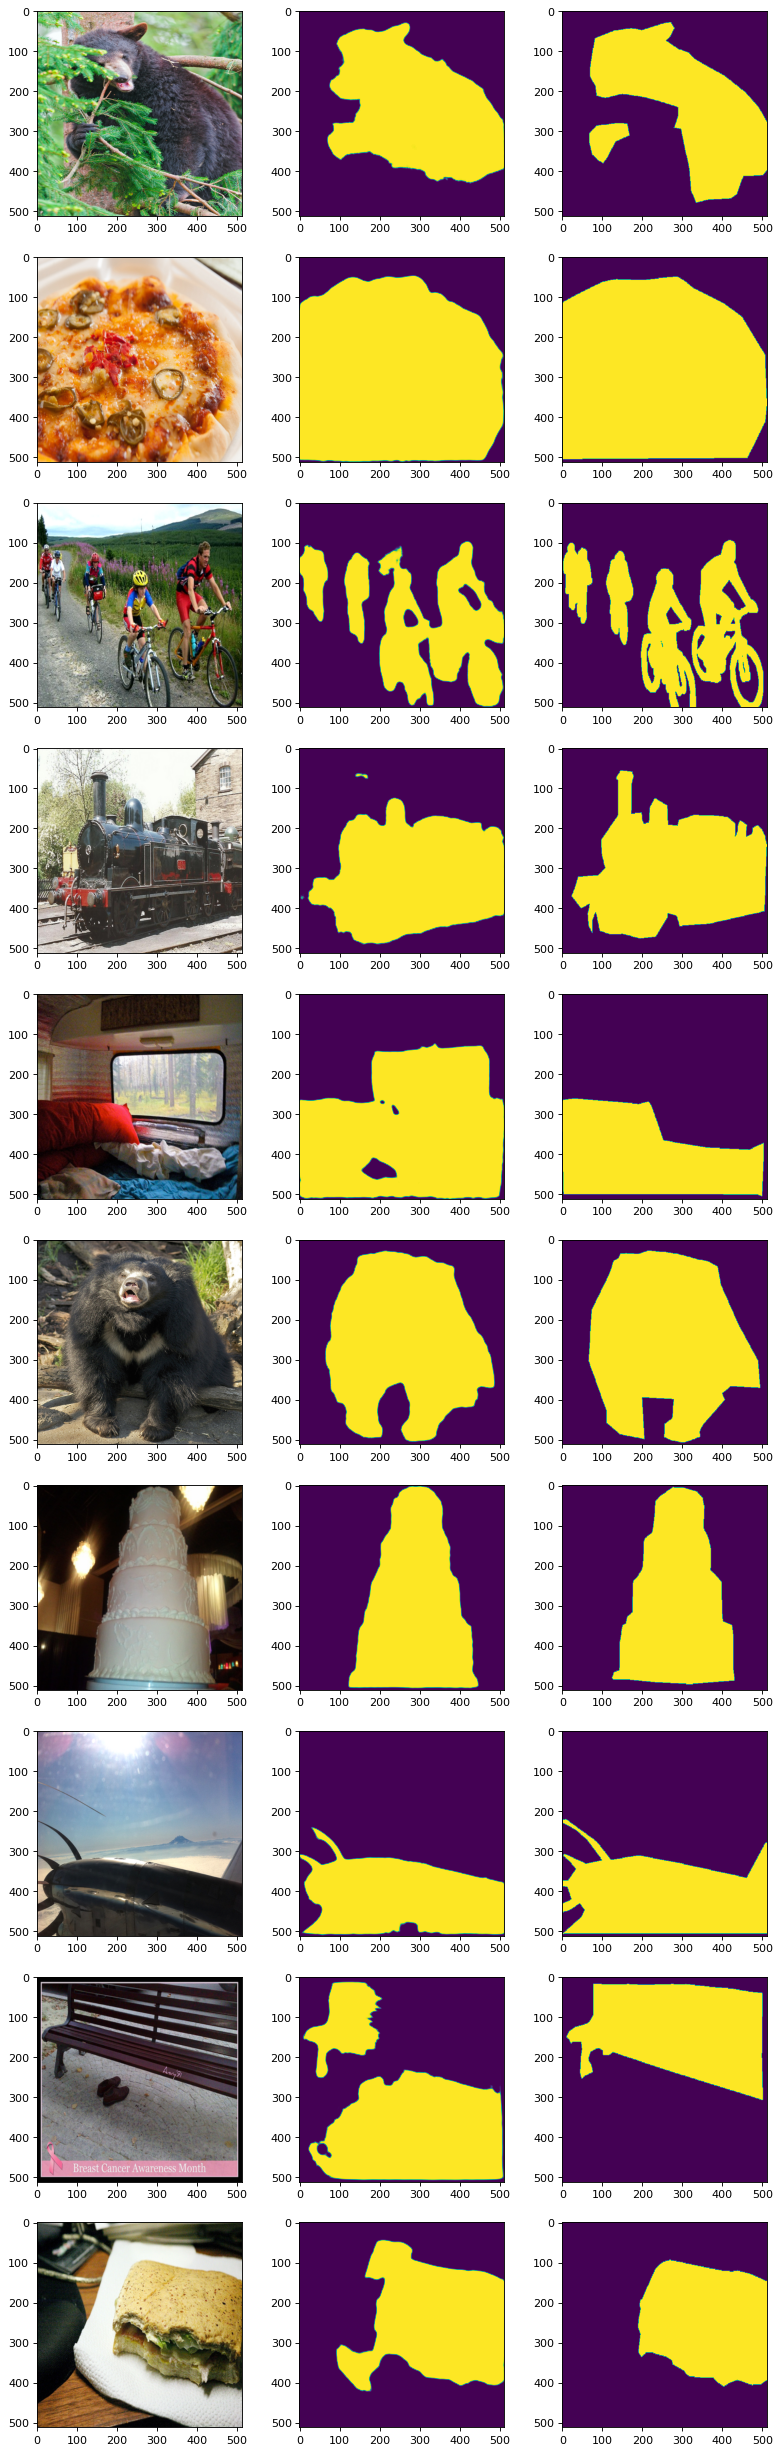

In [21]:
i = 0
fig = plt.figure(figsize=(12, 40), dpi=80)
for i, (X, y) in enumerate(val_dl):
    pred = model(X)
    fig.add_subplot(10, 3, 1+i*3)
    plt.imshow(X[0].permute(1, 2, 0))
    fig.add_subplot(10, 3, 2+i*3)
    plt.imshow(pred[0][0].detach().numpy())
    fig.add_subplot(10, 3, 3+i*3)
    plt.imshow(y[0][0])
    
    if i == 9:
        break
    i+=1
plt.show()

# Inference

In [119]:
import torchvision.transforms as transforms
from PIL import Image
im_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((512, 512))
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [120]:
orig_img = np.array(Image.open('/content/photo_2022-02-27_09-13-30.jpg'))
im = im_transform(orig_img)
pred = model(torch.unsqueeze(im, dim=0))
inv_t = transforms.Resize((orig_img.shape[:2]))
pred = np.array(inv_t(Image.fromarray(pred[0][0].detach().numpy())))
pred = pred > 0.5
matte = orig_img * np.stack([pred, pred, pred]).transpose((1, 2, 0)).astype(np.uint8)
im1 = Image.fromarray(matte).save("geeks.jpg")